# Mean bias

Assessment of model mean bias over the 2000-2019 period.

(Bias corrected data for the period 2000-2019 was produced by training on data from the 1980-1999 period.)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import utils

In [3]:
da_obs = utils.get_npcp_data(
    'tasmax',
    'observations',
    'AGCD',
    'raw',
    'task-reference',
    '2000-01-01',
    '2019-12-31',
    'AU'
)

In [4]:
da_rcm_raw = utils.get_npcp_data(
    'tasmax',
    'CSIRO-ACCESS-ESM1-5',
    'BOM-BARPA-R',
    'raw',
    'task-reference',
    '2000-01-01',
    '2019-12-31',
    'AU'
)

In [5]:
da_rcm_ecdfm = utils.get_npcp_data(
    'tasmax',
    'CSIRO-ACCESS-ESM1-5',
    'BOM-BARPA-R',
    'ecdfm',
    'task-historical',
    '2000-01-01',
    '2019-12-31',
    'AU'
)

In [6]:
da_gcm = utils.get_npcp_data(
    'tasmax',
    'CSIRO-ACCESS-ESM1-5',
    'GCM',
    'raw',
    'task-reference',
    '2000-01-01',
    '2019-12-31',
    'AU'
)

In [7]:
mean_obs = da_obs.groupby('time.year').mean(dim="time").mean(dim='year')

In [8]:
def plot_mean_bias(ax, mean_obs, da_model, cmap, levels, model_name):
    """Plot the mean bias for a particular model"""
    
    mean_model = da_model.groupby('time.year').mean(dim="time").mean(dim='year')
    bias = mean_model - mean_obs
    
    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': 'Temperature (C)'},
    )
    ax.set_title(model_name)
    ax.coastlines()

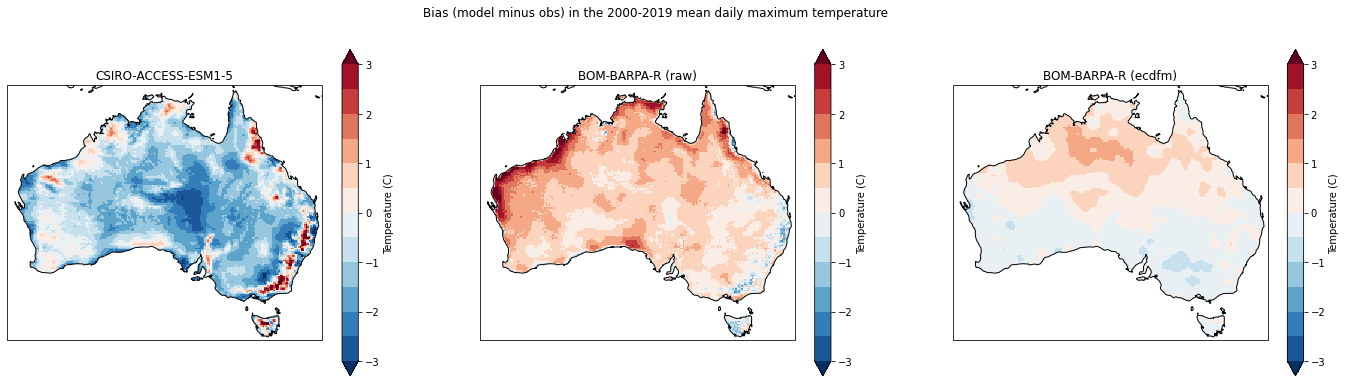

In [9]:
cmap = 'RdBu_r'
levels = np.arange(-3, 3.01, 0.5)

fig = plt.figure(figsize=[24, 6])

ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
plot_mean_bias(
    ax1,
    mean_obs,
    da_gcm,
    cmap,
    levels,
    'CSIRO-ACCESS-ESM1-5',
)

ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
plot_mean_bias(
    ax2,
    mean_obs,
    da_rcm_raw,
    cmap,
    levels,
    'BOM-BARPA-R (raw)'
)

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
plot_mean_bias(
    ax3,
    mean_obs,
    da_rcm_ecdfm,
    cmap,
    levels,
    'BOM-BARPA-R (ecdfm)'
)

plt.suptitle('Bias (model minus obs) in the 2000-2019 mean daily maximum temperature')
plt.show()